In [1]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets
from torchvision import datasets, transforms
import torch
import copy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torchvision.transforms import ToTensor
from torchvision import datasets

# Update the path to where you've manually placed the EMNIST dataset
data = "C:\\Users\\halil\\Documents\\GitHub\\handwritten-letter-recognition-model\\data"  # Change this to the actual path

train_data = datasets.EMNIST(
    root=data,
    split="letters",
    train=True,
    transform=ToTensor(),
    download=False,  # Set to False since you already downloaded it
)

test_data = datasets.EMNIST(
    root=data,
    split="letters",
    train=False,
    transform=ToTensor(),
    download=False,  # Set to False since you already downloaded it
)


In [4]:
len(train_data)+len(test_data)

145600

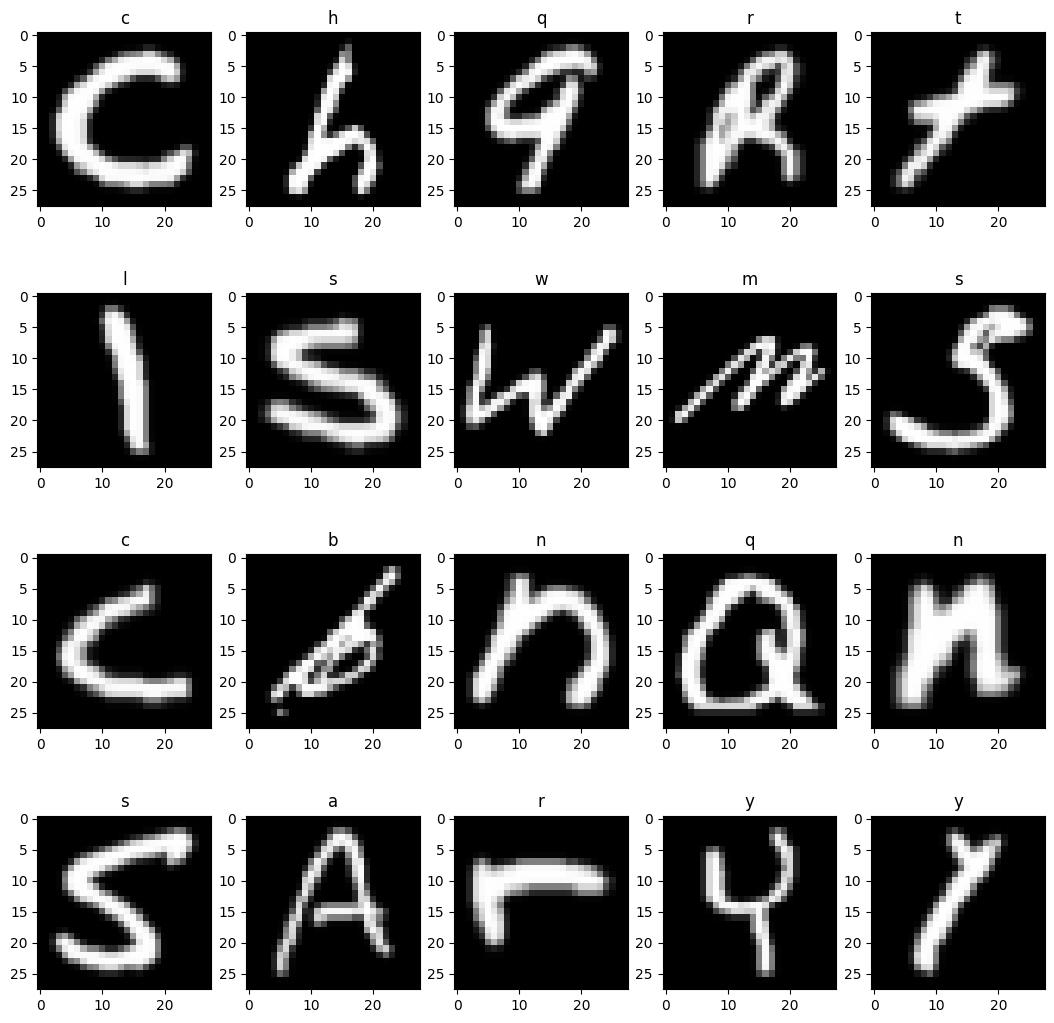

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

image_list, label_list= [], []
for i in range(20):
  number = random.randint(0,len(train_data))
  image, label = train_data[number]
  image_list.append(image)
  label_list.append(label)

fig, axs = plt.subplots(4, 5, figsize=(13, 13))  # Create a subplot with 4 rows and 5 columns
for i, img in enumerate(image_list):  # Loop over the augmented images
    ax = axs[i // 5, i % 5]  # Determine the row and column number for each subplot
    label_name = [k for k, v in train_data.class_to_idx.items() if v == label_list[i]][0]  # Get the class name
    ax.set_title(label_name)  # Set the title for the current subplot
    ax.imshow(np.array(img).squeeze().T, cmap='gray')  # Plot the image  
plt.show()

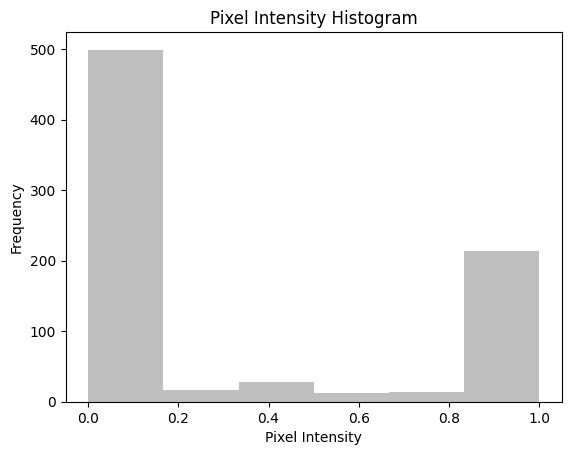

In [6]:
import torch
from torch import nn

# Get an example image and a label.
image, label = train_data[0]

# Flattened the image so we can get the values in a single 1d matrix.
flatten_image = nn.Flatten()
image_flattened = flatten_image(image)

# Creating a histogram to check the mean of the background and foreground.
hist, bin_edges, number_of_x_values= plt.hist(image_flattened, bins=6, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [7]:
# We can calculate back to 784 and check if the histogram is correct.
total_weight = np.sum(hist)

# The sum of the values varying to their intensity levels.
for i in range(len(bin_edges)-1):
  print(hist[i])

# Weight values calculated for self-picked value of 0-1 to background and the rest for foreground.
Wb = (hist[0]+hist[1])/total_weight
Wf = (hist[2]+hist[3]+hist[4]+hist[5])/total_weight

# Calculating the mean variance of the background and foreground values which we self picked before hand.
Ub = ((hist[0]*bin_edges[0])+(hist[1]*bin_edges[1]))/(hist[0]+hist[1])
Uf = ((hist[2]*bin_edges[2])+(hist[3]*bin_edges[3])+(hist[4]*bin_edges[4])+(hist[5]*bin_edges[5]))/(hist[2]+hist[3]+hist[4]+hist[5])

# Getting the variance value based on Otsu's Method to get a number if our self picked number's variance is the best.
variance = math.sqrt((Wb*Wf)*((Ub-Uf)*(Ub-Uf)))

print(f"\nThe threshold we got from the self picked values is {variance}")
print(f"\nThe weight values are: {Wb}, {Wf}")
print(f"\nThe mean intensity values are: {Ub}, {Uf}")

499.0
17.0
28.0
13.0
14.0
213.0

The threshold we got from the self picked values is 0.35608916720360556

The weight values are: 0.6581632653061225, 0.34183673469387754

The mean intensity values are: 0.005490956235994664, 0.7562188917576377


In [8]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

In [9]:
im_otsu = threshold_image(image, variance)

Text(0.5, 1.0, "After Otsu's model")

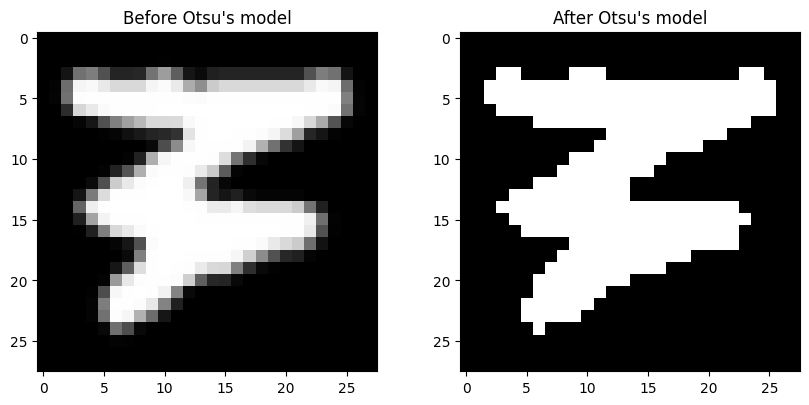

In [10]:

plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title("Before Otsu's model")
plt.subplot(322); plt.imshow(im_otsu.squeeze(),cmap='gray')
plt.title("After Otsu's model")
     

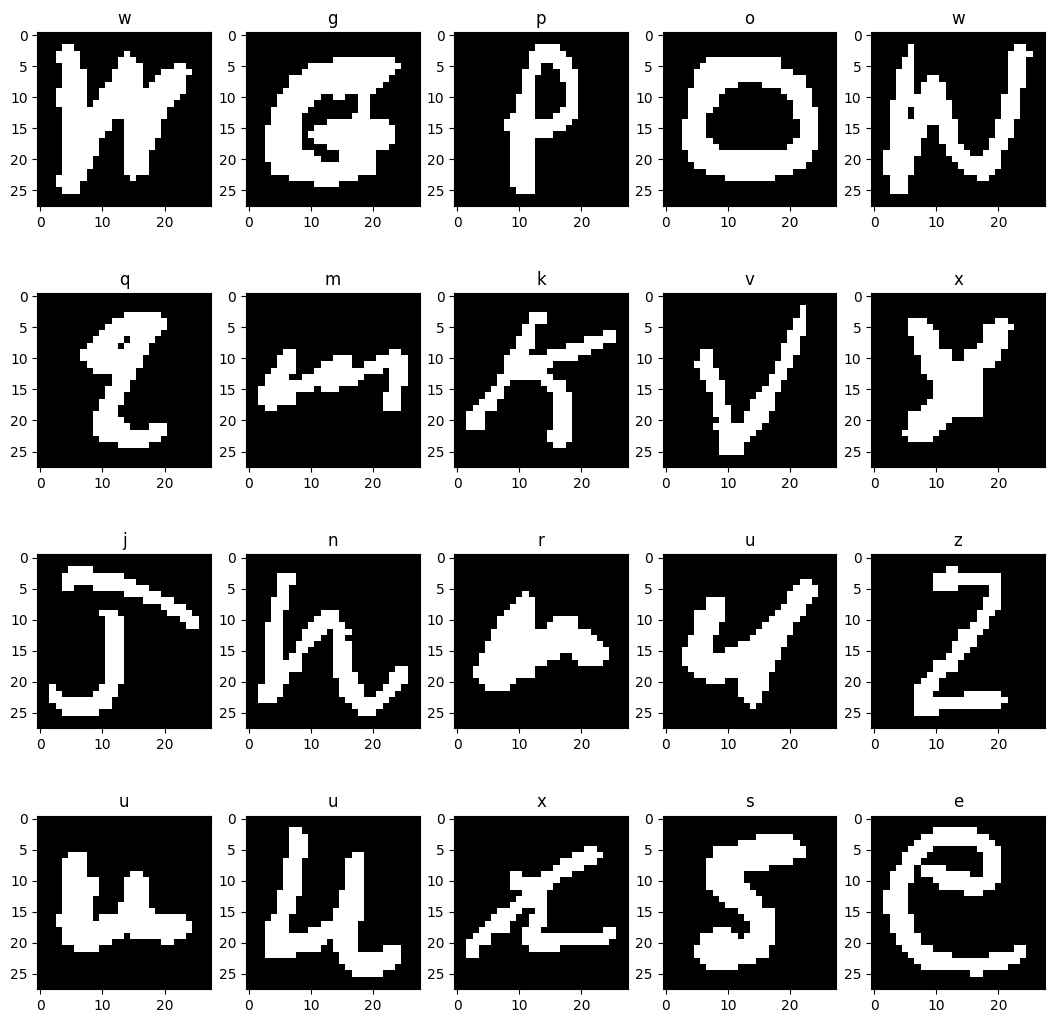

In [11]:
from otsu import findGreatestThreshold

result_list = []
label_list = []  # Initialize label_list

for i in range(20):
    image, label = train_data[i]
    result = findGreatestThreshold(image)
    result_list.append(result)
    label_list.append(label)  # Add the label to label_list
    
fig, axs = plt.subplots(4, 5, figsize=(13, 13))  # Create a subplot with 4 rows and 5 columns
for i, img in enumerate(result_list):  # Loop over the augmented images
    ax = axs[i // 5, i % 5]  # Determine the row and column number for each subplot
    label_name = [k for k, v in train_data.class_to_idx.items() if v == label_list[i]][0]  # Get the class name
    ax.set_title(label_name)  # Set the title for the current subplot
    ax.imshow(np.array(img).squeeze().T, cmap='gray')  # Plot the image  
plt.show()


Otsu's model has been applied for 20 examples. As we can see otsu.py works efficiently and returns clutter free images every time.

In [12]:
train_data.classes, len(train_data.classes)

(['N/A',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'],
 27)

In [13]:
train_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [14]:
letterCategories = train_data.classes[1:]

labels = copy.deepcopy(train_data.targets)-1 

print(torch.sum(labels==0))

torch.unique(labels)

tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [15]:
# Create a list to hold processed images and labels
processed_images_train = []
processed_labels_train = []

# Process each image in the training set
for i in range(len(train_data)):
    image, label = train_data[i]
    
    # Process the image
    processed_image_train = findGreatestThreshold(image)
    
     # Ensure the processed image is a tensor
    if isinstance(processed_image_train, np.ndarray):
        processed_image_train = torch.tensor(processed_image_train)
        label = torch.tensor(label)
    
    processed_image_train = processed_image_train.float()
        
    # Append the processed image and label to the list
    processed_images_train.append(processed_image_train)
    processed_labels_train.append(label)

In [16]:

# Create a list to hold processed images and labels
processed_images_test = []
processed_labels_test = []

# Process each image in the training set
for i in range(len(test_data)):
    image_test, image_label = test_data[i]
    
    # Process the image
    processed_image_test = findGreatestThreshold(image_test)
    
     # Ensure the processed image is a tensor
    if isinstance(processed_image_test, np.ndarray):
        processed_image_test = torch.tensor(processed_image_test)
        image_label = torch.tensor(image_label)
    
    processed_image_test = processed_image_test.float()
        
    # Append the processed image and label to the list
    processed_images_test.append(processed_image_test)
    processed_labels_test.append(image_label)

In [17]:
# Create a new dataset with the processed images
class ProcessedEMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Convert lists to torch tensors if not already
processed_images_train = torch.stack(processed_images_train)
processed_labels_train = torch.tensor(processed_labels_train)

# Convert lists to torch tensors if not already
processed_images_test = torch.stack(processed_images_test)
processed_labels_test = torch.tensor(processed_labels_test)


# Create the new dataset
processed_train_data = ProcessedEMNISTDataset(processed_images_train, processed_labels_train)

# Create the new dataset
processed_test_data = ProcessedEMNISTDataset(processed_images_test, processed_labels_test)

In [18]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [19]:
len(processed_train_data), len(processed_test_data)

(124800, 20800)

In [20]:
# Assuming train_data is a Dataset object from torchvision.datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)

# We only need to get one batch since the batch size is the whole dataset
images, _ = next(iter(train_loader))

# Calculate the mean and standard deviation
mean = images.mean()
std = images.std()

In [21]:
class AugmentDataset(Dataset):
  def __init__(self, images, labels, augment):
    self.images = images
    self.labels = labels
    # Define the data augmentation of images
    self.transform = augment

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    lab = self.labels[idx]
    if self.transform:
      img = self.transform(img)
    return img, lab

# A combination of five data augmentation techniques,
# including rotation, shearing, shifting up and down, zooming, and rescale
augment = transforms.Compose([
    transforms.ToPILImage(),  # Convert the images to PIL Image objects
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=3),
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))  # mean, std = 0.1736, 0.3248
])


In [23]:
# Create instances of AugmentDataset
train_dataset = AugmentDataset(processed_images_train, processed_labels_train, augment)
test_dataset = AugmentDataset(processed_images_test, processed_labels_test, None)  # No augmentation for testing data

In [24]:
BATCH_SIZE = 16

combined_dataset = ConcatDataset([processed_train_data, train_dataset])

train_dataloader = DataLoader(combined_dataset, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 15600 iterations with the batch size of 16.
For testing data there is 1300 iterations with the batch size of 16.


In [25]:
import torch
from torch import nn
import torch.nn.functional as F

class LetterRecognizerModel4(nn.Module):
    def __init__(self, input_size, output_size):
        super(LetterRecognizerModel4, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128*3*3, 512),
            #nn.BatchNorm4d(512),
            nn.Dropout(0.25),
            
            nn.Linear(512, 256),
            #nn.BatchNorm4d(256),
            nn.Dropout(0.55),
            
            nn.Linear(256, output_size)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

torch.manual_seed(42)

model_4 = LetterRecognizerModel4(input_size=1, output_size=len(train_data.classes)).to(device)

model_4


LetterRecognizerModel4(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.55, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.55, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                             lr=0.0001)

In [27]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [28]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [29]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [30]:
from tqdm.auto import tqdm

torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_4 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 25
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_4,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_4,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_4 = timer()
total_train_time_model_4 = print_train_time(start=train_time_start_model_4,
                                           end=train_time_end_model_4,
                                           device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

Train loss is:3.57927, Train accuracy is:3.97%
Test loss is:3.293597, Test accuracy is:1.735577%
Epoch: 0
---------
Train loss is:3.12314, Train accuracy is:16.10%
Test loss is:2.924125, Test accuracy is:33.072115%
Epoch: 1
---------
Train loss is:2.30117, Train accuracy is:41.20%
Test loss is:1.931620, Test accuracy is:53.716346%
Epoch: 2
---------
Train loss is:1.71465, Train accuracy is:53.64%
Test loss is:1.458210, Test accuracy is:63.721154%
Epoch: 3
---------
Train loss is:1.42260, Train accuracy is:60.58%
Test loss is:1.193884, Test accuracy is:69.269231%
Epoch: 4
---------
Train loss is:1.22837, Train accuracy is:65.30%
Test loss is:1.020379, Test accuracy is:72.884615%
Epoch: 5
---------
Train loss is:1.09023, Train accuracy is:68.70%
Test loss is:0.900243, Test accuracy is:75.447115%
Epoch: 6
---------
Train loss is:0.98999, Train accuracy is:71.20%
Test loss is:0.812000, Test accuracy is:77.466346%
Epoch: 7
---------
Train loss is:0.90970, Train accuracy is:73.34%
Test loss 

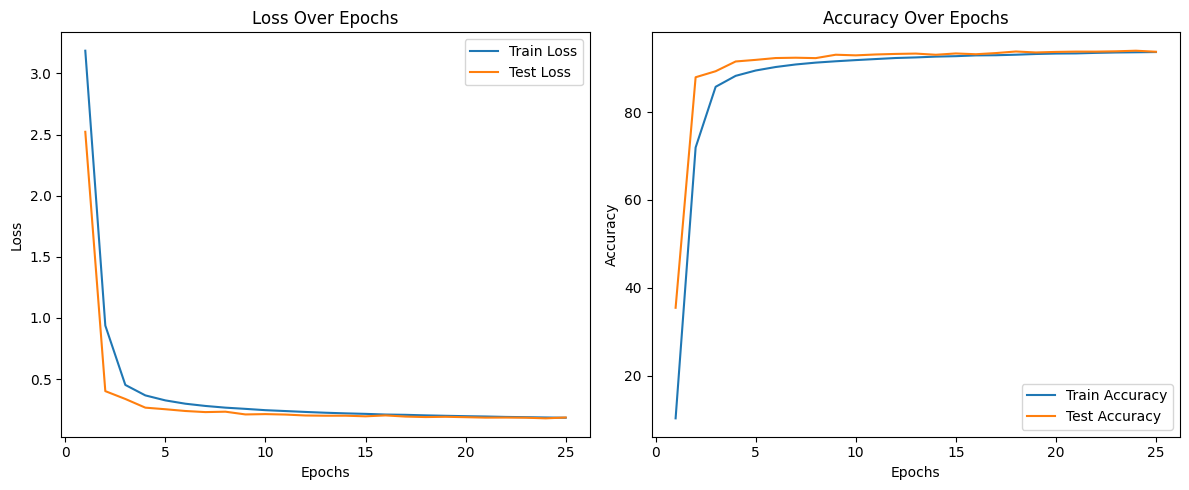

In [194]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [195]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_4_results = eval_model(model=model_4, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_func,
    device=device
)
model_4_results

{'model_name': 'LetterRecognizerModel4',
 'model_loss': 0.18525813519954681,
 'model_acc': 93.7548076923077}